In [1]:
#creating baseline model

import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('train_data (1).csv')
df.head()

,0,1
0,"This film is absolutely awful, but nevertheles...",0
1,Well since seeing part's 1 through 3 I can hon...,0
2,I got to see this film at a preview and was da...,1
3,This adaptation positively butchers a classic ...,0
4,Råzone is an awful movie! It is so simple. It ...,0


In [3]:
df.dropna(inplace=True)

In [4]:
df.shape

(25000, 2)

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.shape

(24904, 2)

In [7]:
df = df[~(df['0'].str.strip() == '')]

In [8]:
df.rename(columns={'0': 'clean_comment'}, inplace=True)
df.rename(columns={'1': 'category'}, inplace=True)

In [9]:
df.head()

,clean_comment,category
0,"This film is absolutely awful, but nevertheles...",0
1,Well since seeing part's 1 through 3 I can hon...,0
2,I got to see this film at a preview and was da...,1
3,This adaptation positively butchers a classic ...,0
4,Råzone is an awful movie! It is so simple. It ...,0


In [10]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [11]:
url_pattern = r'http[s]?://(?:[a-zA-Z0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

# Ensure strings (handle NaN), remove URLs, normalize spaces, strip edges
df['clean_comment'] = (df['clean_comment'].astype(str).str.replace(url_pattern, '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip())

In [12]:
# NLTK data downloaded
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\latif\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\latif\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
def preprocess_comment(comment):
    # Convert to lowercase
    comment = comment.lower()

    # Remove trailing and leading whitespaces
    comment = comment.strip()

    # Remove URLs (http, https)
    comment = re.sub(r'http[s]?://\S+', '', comment)

    # Remove newline characters
    comment = re.sub(r'\n', ' ', comment)

    # Remove non-alphanumeric characters, except punctuation
    comment = re.sub(r'[^A-Za-z0-9\s!?.,]', '', comment)

    # Remove stopwords but retain important ones for sentiment analysis
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'however', 'no', 'yet'}
    comment = ' '.join([word for word in comment.split() if word not in stop_words])

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])

    return comment

In [14]:
# Apply the preprocessing function to the 'clean_comment' column
df['clean_comment'] = df['clean_comment'].apply(preprocess_comment)

In [15]:
df.head()

,clean_comment,category
0,"film absolutely awful, but nevertheless, hilar...",0
1,well since seeing part 1 3 honestly say never ...,0
2,got see film preview dazzled it. not typical r...,1
3,adaptation positively butcher classic beloved ...,0
4,rzone awful movie! simple. seems tried make mo...,0


In [16]:
df.shape

(24904, 2)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [18]:
# Step 1: Vectorize the comments using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))  # TF-IDF model with a limit of 10000 features

In [19]:
X = vectorizer.fit_transform(df['clean_comment'])
y = df['category']  # Assuming 'sentiment' is the target variable (0 or 1 for binary classification)

In [20]:
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2577875 stored elements and shape (24904, 10000)>

In [22]:
X.shape

(24904, 10000)

In [23]:
y

0        0
1        0
2        1
3        0
4        0
        ..
24995    1
24996    1
24997    1
24998    1
24999    1
Name: category, Length: 24904, dtype: int64

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
lr = LogisticRegression(random_state=42, max_iter=1000)

In [27]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'solver': ['liblinear', 'lbfgs']},
             scoring='accuracy')

In [28]:
best_lr = grid_search.best_estimator_
best_lr.fit(X_train, y_train)
y_pred = best_lr.predict(X_test)

In [29]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best Hyperparameters: {'C': 10, 'solver': 'lbfgs'}
Accuracy: 0.8950
Precision: 0.8950
Recall: 0.8950
F1-score: 0.8950

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89      2486
           1       0.89      0.90      0.90      2495

    accuracy                           0.90      4981
   macro avg       0.90      0.89      0.90      4981
weighted avg       0.90      0.90      0.90      4981



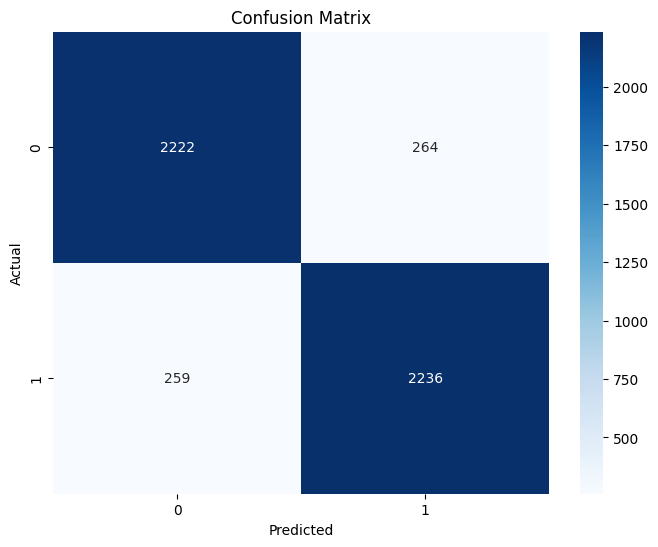

In [30]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
plt.savefig("confusion_matrix_baseline1.png", dpi=300, bbox_inches='tight')